# Import dependencies

In [1]:
!pip install keras

In [2]:
!pip install cython

In [3]:
import sys
sys.path.append('Mask_RCNN')

In [4]:
import os
import sys
import random
import math
import re
import time

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
#sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import imageio
import skimage
from config import Config
from skimage.morphology import label
from skimage.feature import canny
from skimage import exposure
from keras.callbacks import Callback
from skimage.morphology import binary_closing, binary_opening, disk, binary_dilation
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.externals import joblib
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.morphology import watershed
from skimage.filters import sobel
from preparation import vgg_feature_extractor
from random import *

import gc; gc.enable()
import utils
import model as modellib
import visualize
from model import log

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let's download the mask_rcnn trained on COCO dataset to initialize the model.

In [5]:
pd.options.display.max_rows=100

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

We will now define the monitor that will help keep track on the training process.
With this you will be able to see your charts in the `charts` tab

Now we will load the metadata and divide them in train and valid splits

In [6]:
TRAIN_PATH = '../stage1_train'
TEST_PATH = '../stage1_test'
META_DATA_PATH = '../stage1_metadata.csv'
BG_DATA_PATH = '../stage1_backgroud_foreground_classes.csv'

In [7]:
if not os.path.exists(META_DATA_PATH):
    print('Generating metadata.csv')
    
    stage1_metadata = pd.DataFrame()
    
    train_image_ids = os.listdir(TRAIN_PATH) # ImageId
    train_is_train = [1] * len(train_image_ids)
    
    train_file_path = []
    for p in train_image_ids:
        if p[:4] == 'TCGA':
            train_file_path.append(TRAIN_PATH + '/' + p + '/images/' + p + '.tif')
        else:
            train_file_path.append(TRAIN_PATH + '/' + p + '/images/' + p + '.png')
    
    test_image_ids = os.listdir(TEST_PATH) # ImageId
    test_is_train = [0] * len(test_image_ids)
    test_file_path = [TEST_PATH + '/' + p + '/images/' + p + '.png' for p in test_image_ids]
    
    stage1_metadata['ImageId'] = np.concatenate([train_image_ids, test_image_ids], axis=0)
    stage1_metadata['is_train'] = np.concatenate([train_is_train, test_is_train], axis=0)
    stage1_metadata['file_path_image'] = np.concatenate([train_file_path, test_file_path], axis=0)
    
    ve = vgg_feature_extractor(n_clusters=10)
    train_vgg_features_clusters = ve.get_vgg_clusters(stage1_metadata[stage1_metadata.is_train == 1].reset_index(drop=True), is_train=True)
    test_vgg_features_clusters =ve.get_vgg_clusters(stage1_metadata[stage1_metadata.is_train == 0].reset_index(drop=True), is_train=False)
    
    stage1_metadata['vgg_features_clusters'] = np.concatenate([train_vgg_features_clusters, test_vgg_features_clusters], axis=0)
    
    stage1_metadata.to_csv(META_DATA_PATH, index=False)
    meta = stage1_metadata
    
    del vgg_feature_extractor; gc.collect()
else:
    meta = pd.read_csv(META_DATA_PATH)
    

meta.head(100)

,ImageId,is_train,file_path_image,vgg_features_clusters
0,ef6634efb46567d87b811be786b18c4cd0e2cda23d79b6...,1,../stage1_train/ef6634efb46567d87b811be786b18c...,1
1,351771edfc5db5665ded8aa4940257276b6526663c76e3...,1,../stage1_train/351771edfc5db5665ded8aa4940257...,6
2,785555c0cbb49dad835635217085287a8cc61c27d26f0e...,1,../stage1_train/785555c0cbb49dad83563521708528...,4
3,7ba20aa731cc21af74a8d940254176cbad1bdc44f240b5...,1,../stage1_train/7ba20aa731cc21af74a8d940254176...,1
4,43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1f...,1,../stage1_train/43cf6b2ec0b0745ac2b87b4d8780f6...,3
5,0b2e702f90aee4fff2bc6e4326308d50cf04701082e718...,1,../stage1_train/0b2e702f90aee4fff2bc6e4326308d...,4
6,61dc249314d7b965eb4561ec739eab9b0f60af55c97b25...,1,../stage1_train/61dc249314d7b965eb4561ec739eab...,6
7,28d33efef218392e79e385906deb88055d94b65ad217de...,1,../stage1_train/28d33efef218392e79e385906deb88...,0
8,4596961c789d3b41916492918797724fe75128239fefc5...,1,../stage1_train/4596961c789d3b4191649291879772...,6
9,1ec74a26e772966df764e063f1391109a60d803cff9d15...,1,../stage1_train/1ec74a26e772966df764e063f13911...,9


In [8]:
back_ground_df = pd.read_csv(BG_DATA_PATH)
back_ground_df.tail(100)

,filename,foreground,background
665,589f86dee5b480a88dd4f77eeaffe2c4d70aefdf879a40...,purple,purple
666,442c4eb0185698fe7d148c108a46f74abd399aecda2f4f...,purple,purple
667,709e094e39629a9ca21e187f007b331074694e443db402...,purple,purple
668,6b0ac2ab04c09dced54058ec504a4947f8ecd5727dfca7...,purple,purple
669,87ea72894f6534b28e740cc34cf5c9eb75d0d8902687fc...,purple,purple
670,b0e35e06b85da49bfe3ea737711a72b551a6add446e30e...,purple,purple
671,f952cc65376009cfad8249e53b9b2c0daaa3553e897096...,purple,purple
672,6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c...,purple,purple
673,e49fc2b4f1f39d481a6525225ab3f688be5c87f5688445...,purple,purple
674,a90401357d50e1376354ae6e5f56a2e4dff3fdb5a4e8d5...,purple,purple


In [9]:
back_ground_df['ImageId'] = [fn.replace('.png', '') if fn[-4:] == '.png' else fn.replace('.tif', '') for fn in back_ground_df.filename]
print('Image ID in background data counts:\n', meta.ImageId.isin(back_ground_df.ImageId).value_counts())

Image ID in background data counts:
 True    759
Name: ImageId, dtype: int64


In [10]:
back_ground_df.background.value_counts()

black     599
purple    101
white      57
yellow      8
Name: background, dtype: int64

In [11]:
back_ground_df.foreground.value_counts()

white     599
purple    150
black      16
Name: foreground, dtype: int64

In [12]:
back_ground_df['composed_bf_ground'] = back_ground_df.background.astype(str) + '_' + back_ground_df.foreground.astype(str)
back_ground_df.composed_bf_ground.value_counts()

black_white      599
purple_purple    101
white_purple      41
white_black       16
yellow_purple      8
Name: composed_bf_ground, dtype: int64

### How to deal with it:
1. yellow_purple, white_black -> reverse to black_white
2. white_purple, purple_purple -> change to white black. (the foreground seems darker in these cases)
3. Separate into two groups: 1. + 2.

In [13]:
back_ground_df = back_ground_df.set_index('ImageId')
back_ground_df.head(10)

,filename,foreground,background,composed_bf_ground
ImageId,,,,
d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf,d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...,white,black,black_white
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0,4596961c789d3b41916492918797724fe75128239fefc5...,white,black,black_white
b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39ff843884d84f61dee1,b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...,white,black,black_white
831218e6a1a54b23d4be56c5799854e7eb978811b89215319dc138900bd563e6,831218e6a1a54b23d4be56c5799854e7eb978811b89215...,white,black,black_white
b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229,b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...,white,black,black_white
4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e,4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16...,white,black,black_white
43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1fcefa42d166191e84c6,43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1f...,white,black,black_white
f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8bc639d4121c1672ff7,f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8...,white,black,black_white
bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6,bf7691b0a79811fa068b7408cbce636a73f01ef9e971a9...,white,black,black_white


In [14]:
meta['bg_type'] = meta.ImageId.map(back_ground_df.composed_bf_ground)
meta['bg_type'].value_counts()

black_white      594
purple_purple    100
white_purple      41
white_black       16
yellow_purple      8
Name: bg_type, dtype: int64

In [15]:
meta[meta['is_train']==1].bg_type.value_counts()

black_white      541
purple_purple     99
white_purple      38
white_black       16
Name: bg_type, dtype: int64

In [16]:
meta[meta['is_train']==0].bg_type.value_counts()

black_white      53
yellow_purple     8
white_purple      3
purple_purple     1
Name: bg_type, dtype: int64

In [17]:
meta['process_type'] = meta['bg_type'].map({
    'black_white': 2, # do nothing
    'white_black': 3, # pure reverse
    'purple_purple': 1, # turns into gray and reverse
    'yellow_purple': 1, # turns into gray and reverse
    'white_purple': 1 # turns into gray and reverse
})
meta['process_type'].value_counts()

2    594
1    149
3     16
Name: process_type, dtype: int64

In [18]:
meta['group'] = meta['bg_type'].map({
    'black_white': 0,
    'white_black': 0,
    'purple_purple': 0,
    'yellow_purple': 0,
    'white_purple': 0
})
meta['group'].value_counts()

0    759
Name: group, dtype: int64

In [19]:
def train_val_split(meta_train, val_size=0.1, random_state=719):
    meta_train_groups = [meta_train[meta_train['group'] == group].reset_index(drop=True) for group in range(1)]
    
    meta_train_val_groups = []
    
    for train_group in meta_train_groups:
        meta_train_val_groups
        val = train_group.sample(frac=val_size, random_state=random_state)
        tr = train_group[~train_group.index.isin(val.index)]
        
        meta_train_val_groups.append((tr, val))
    
    return meta_train_val_groups

def train_split(meta_train):
    meta_train_groups = [meta_train[meta_train['group'] == group].reset_index(drop=True) for group in range(2)]
    return meta_train_groups

In [20]:
IS_DEVELOP = False
if IS_DEVELOP:
    VAL_SIZE = .3
else:
    VAL_SIZE = 0.01

In [21]:
meta_train = meta[meta['is_train']==1]
meta_test = meta[meta['is_train']==0]
meta_train_val_groups = train_val_split(meta_train, val_size=VAL_SIZE, random_state=519)

for i in range(1):
    print(meta_train_val_groups[i][0].shape, meta_train_val_groups[i][1].shape)

(687, 7) (7, 7)


# Mask-RCNN configuration
We will now define parameters for our mask-rcnn. 
Tweak them to get better results!

In [22]:
class DsbConfig(Config):

    # Give the configuration a recognizable name
    NAME = "dsb"
      
    LEARNING_RATE = 1e-2
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution image
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Train on 1 GPU and 8 images per GPU. Batch size is GPUs * images/GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
    # typically be equal to the number of samples of your dataset divided by the batch size
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 70

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleis
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_PADDING = True  # currently, the False option is not supported
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels, maybe add a 256?
    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 320 #300
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14 # 14
    MASK_SHAPE = [28, 28] # 28
    TRAIN_ROIS_PER_IMAGE = 512
    RPN_DETECTION_MIN_CONFIDENCE = .6
    RPN_NMS_THRESHOLD = 0.6 #0.7
    MAX_GT_INSTANCES = 256
    DETECTION_MAX_INSTANCES = 450 
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.67 # may be smaller?
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3 # 0.3
    
    # DETECTION_MAX_INSTANCES=400, DETECTION_MIN_CONFIDENCE=.7 => Val loss: .21xx, LB: .424
    # DETECTION_MAX_INSTANCES=450, DETECTION_MIN_CONFIDENCE=.65 => Val loss: .3, LB: .438
    # DETECTION_MAX_INSTANCES=, DETECTION_MIN_CONFIDENCE= => Val loss: ., LB: .
    
    '''
    0324 note: 
        RPN_NMS_THRESHOLD .7 -> .6 to generate more proposals at training,
        DETECTION_MAX_INSTANCES 400 -> 450
        DETECTION_MIN_CONFIDENCE .7
        BACKBONE_STRIDES add `2` ..?
    '''
    
    MEAN_PIXEL = np.array([0.,0.,0.])
    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    
    # Min Box Size
    MIN_BOX_SIZE = 36./(512.**2.) # (36/512**2) (delete objects smaller than 6*6 pixels)
    BORDER_RATIO = 4. / 512. # smaller than 4 pixels width\height at the border
    BORDER_MIN_BOX_SIZE = 16./(512.**2.)
  
    LR_SHRINK_PERIOD = 10
    
config = DsbConfig()

# Agument functions

In [23]:
class Agg_Func():
    def __init__(self, funcs=[]):
        self.funcs = funcs
        
    def __call__(self, x):
        res = x
        for f in self.funcs:
            res = f(res)
        return res

In [24]:
class Augment():
    def __init__(self, rotate=True, flip=True):
        self.augment_funcs = []
        
        if flip:   
            self.augment_funcs.extend([
                Agg_Func(funcs=[]),
                Agg_Func(funcs=[np.fliplr]),
                Agg_Func(funcs=[np.flipud]),
                Agg_Func(funcs=[np.fliplr, np.flipud]),
            ])
            
            if rotate:
                self.augment_funcs.extend([
                    Agg_Func(funcs=[np.rot90]),
                    Agg_Func(funcs=[np.rot90, np.fliplr]),
                    Agg_Func(funcs=[np.rot90, np.flipud]),
                    Agg_Func(funcs=[np.rot90, np.fliplr, np.flipud]),
                ])
        elif rotate:
            self.augment_funcs.extend([
                Agg_Func(funcs=[]),
                Agg_Func(funcs=[np.rot90]),
            ])
    
    def get_random_augement(self):
        index = randrange(len(self.augment_funcs))
        return self.augment_funcs[index]
    
    def apply_all_augment(self, img):
        res = []
        for f in self.augment_funcs:
            res.append(f(img))
        return res

# Dataset definition

We need to define our datasets for the data science bowl competition

In [25]:
class DsbDataset(utils.Dataset):

    '''
    process_info is a image-id <=> process type mapping pd.series
    '''
    def load_dataset(self, process_info, train_mode=True, augment=False):
        self.add_class("dsb", 1, "nuclei")
        self.process_info = process_info
        self.augmenter = Augment()
        self.augment = augment
        
        if train_mode:
            directory = dsb_dir
        else:
            directory = test_dir
            
        ids = []
        for i, id in enumerate(process_info.ImageId.values):
            image_dir = os.path.join(directory, id)
            self.add_image("dsb", image_id=i, path=image_dir)
            ids.append(i)
        
        self.process_info.reset_index(drop=True, inplace=True)
        #print(self.process_info)
        self.process_info['id'] = ids
        self.process_info.set_index('id')
        self.process_info = self.process_info['process_type']
        #print(self.process_info)
        
    def load_image(self, image_id, non_zero=None):
        info = self.image_info[image_id]
        path = info['path']
        image_name = os.listdir(os.path.join(path, 'images'))
        image_path = os.path.join(path, 'images', image_name[0])
        image = imageio.imread(image_path)
        
        #print(self.process_info[image_id])
        if image_path[-4:] == '.tif':
            self.offset = (randrange(488), randrange(488))
            image = image[self.offset[0]:self.offset[0]+512, self.offset[1]:self.offset[1]+512, :]
            #image = skimage.transform.resize(image, (512,512),  preserve_range=True)
        
        if image.shape[2] != 3:
            image = image[:,:,:3]

        image = self.preprocess(image, process_type=self.process_info[image_id])
        image = image.astype('float32')
        
        if self.augment:
            self.augment_func = self.augmenter.get_random_augement()
            image = self.augment_func(image)
            
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        mask_dir = os.path.join(path, 'masks')
        mask_names = os.listdir(mask_dir)
        count = len(mask_names)
        mask = []
        
        for i, el in enumerate(mask_names):
            msk_path = os.path.join(mask_dir, el)
            msk = imageio.imread(msk_path)
            if np.sum(msk) == 0:
                print('invalid mask')
                continue
                
            if 'TCGA' in mask_dir:
                #msk = skimage.transform.resize(msk, (512,512), preserve_range=True)
                msk = msk[self.offset[0]:self.offset[0]+512, self.offset[1]:self.offset[1]+512]
                if np.sum(msk) == 0:
                    continue
                
            msk = msk.astype('float32')/255.
            
            if len(msk.shape) > 2:
                msk = np.sum(msk, axis=2)
                
            mask.append(msk)
            
        try:
            mask = np.array(mask)
        except:
            for i, m in enumerate(mask):
                if len(m.shape) > 2:
                    print(mask_names[i])
                    
        mask[mask > 0.] = 1.
        mask = np.transpose(mask, (1,2,0))
        if self.augment:
            mask = self.augment_func(mask) # self.augment_func was decided when loading image before loading masks
            
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        count = mask.shape[2]
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = [self.class_names.index('nuclei') for s in range(count)]
        class_ids = np.asarray(class_ids)
        
        return mask, class_ids.astype(np.int32)
    
    def preprocess(self, img, process_type=0):
        
        if process_type == 0: # grey-rgb-grey
            gray = skimage.color.rgb2gray(img.astype('uint8'))
            img = skimage.color.gray2rgb(gray)
            img *= 255.
        elif process_type == 1:  # grey-rgb-grey-reverse
            gray = skimage.color.rgb2gray(img.astype('uint8'))
            img = skimage.color.gray2rgb(gray)
            img *= 255.
            img = 255. - img
        elif process_type == 2:
            img = img.astype(float)
            pass # do nothing
        elif process_type == 3:
            img = img.astype(float)
            img = 255. - img
        
        return img

In [26]:
dsb_dir = TRAIN_PATH
test_dir = TEST_PATH

In [27]:
'''
for i in range(2):
    print(meta_train_val_groups[i][0].shape, meta_train_val_groups[i][1].shape)
'''

datasets = []
for i in range(1):
    
    tr, val = meta_train_val_groups[i]

    # Training dataset
    dataset_train = DsbDataset()
    dataset_train.load_dataset(tr[['ImageId', 'process_type']], augment=True)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = DsbDataset()
    dataset_val.load_dataset(val[['ImageId', 'process_type']])
    dataset_val.prepare()
    
    datasets.append((dataset_train, dataset_val))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Let's take a look at some images

Loading group= 0
image shape= (696, 520, 3) mask shape= (696, 520, 23) bg type= black_white process type= 2


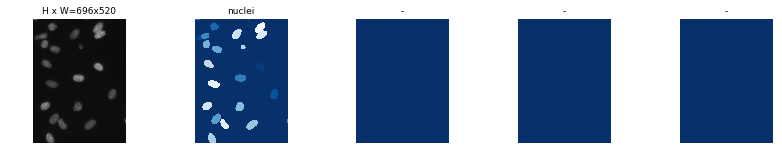

image shape= (360, 360, 3) mask shape= (360, 360, 26) bg type= black_white process type= 2


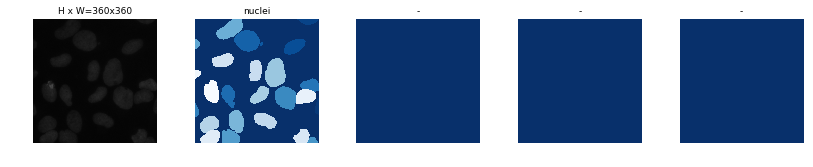

image shape= (1024, 1024, 3) mask shape= (1024, 1024, 57) bg type= white_black process type= 3


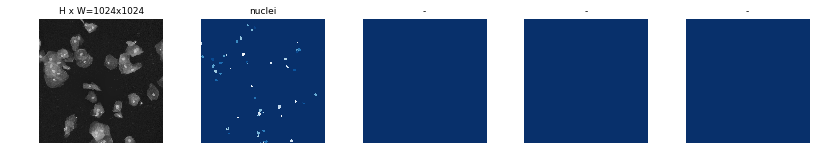

/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


image shape= (512, 512, 3) mask shape= (512, 512, 88) bg type= purple_purple process type= 1


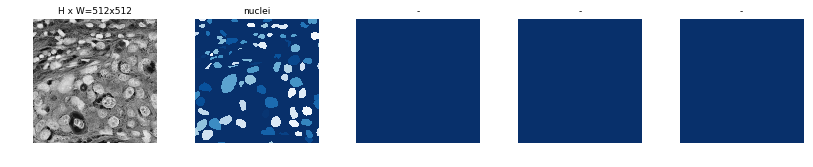

image shape= (256, 320, 3) mask shape= (256, 320, 51) bg type= white_purple process type= 1


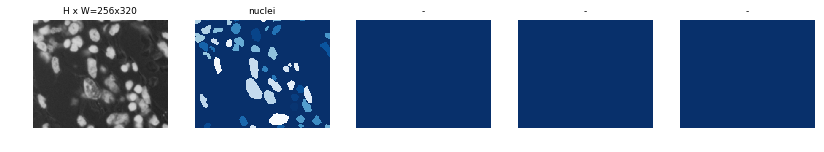

image shape= (256, 256, 3) mask shape= (256, 256, 8) bg type= black_white process type= 2


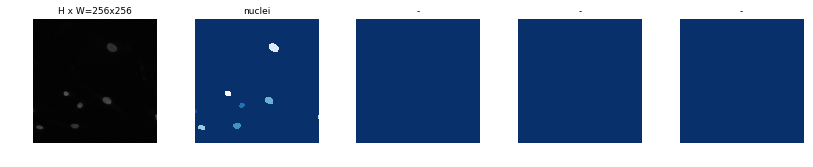

image shape= (256, 320, 3) mask shape= (256, 320, 30) bg type= purple_purple process type= 1


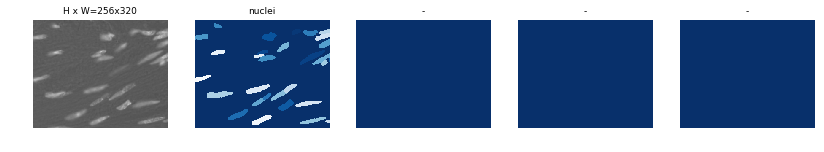

image shape= (256, 256, 3) mask shape= (256, 256, 56) bg type= black_white process type= 2


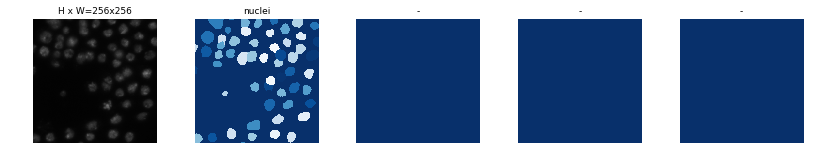

image shape= (256, 256, 3) mask shape= (256, 256, 32) bg type= black_white process type= 2


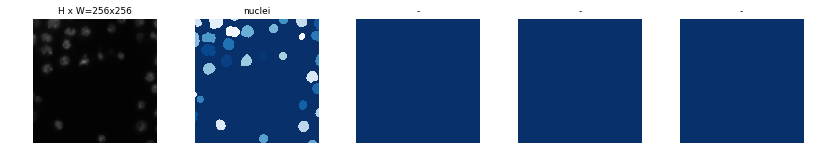

image shape= (256, 256, 3) mask shape= (256, 256, 53) bg type= black_white process type= 2


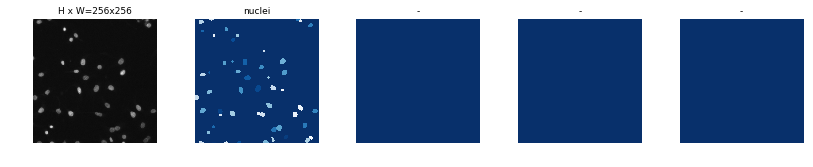

In [28]:
for i in range(1):    
    dataset_train, _ = datasets[i]
    
    #image_ids = dataset_train.image_ids
    image_ids = np.random.choice(dataset_train.image_ids, 10)
    print('Loading group=',i)
    for image_id in image_ids:
        image = dataset_train.load_image(image_id)

        mask, class_ids = dataset_train.load_mask(image_id)
        
        print('image shape=', image.shape, 'mask shape=', mask.shape, 
              'bg type=', meta_train_val_groups[i][0].bg_type.values[image_id],
              'process type=', meta_train_val_groups[i][0].process_type.values[image_id])
        visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Model Training

OK! 

I think we are ready to do some training!
We will instantiate the model and initialize it with COCO weights

In [29]:
if IS_DEVELOP:
    epochs = [10, 10]
    lr_shrink_period = [5, 5]
    inital_lr = 0.01
else:
    epochs = [100, 200]
    lr_shrink_period = [100, 150]
    inital_lr = 0.001
    
for i in range(1):
    train_index = i
    
    dataset_train, dataset_val = datasets[train_index]
    
    config.LEARNING_RATE = inital_lr
    config.LR_SHRINK_PERIOD = lr_shrink_period[train_index]
    config.STEPS_PER_EPOCH = len(dataset_train.image_ids) // config.IMAGES_PER_GPU
    
    model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
    
    init_with = "coco"  # imagenet, coco, or last

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last()[1], by_name=True)
        
    model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE,
                epochs=epochs[train_index], 
                layers="all", clbcks=[])

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /data/khyeh/logs/dsb20180410T0123/mask_rcnn_dsb_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a       

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


116/343 [=========>....................] - ETA: 8:58 - loss: 1.8627 - rpn_class_loss: 0.2236 - rpn_bbox_loss: 0.8088 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3252

/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:7472: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)
/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:3284: UserWarning: invalid tile data
  warnings.warn("invalid tile data")


203/343 [================>.............] - ETA: 5:25 - loss: 1.6398 - rpn_class_loss: 0.1704 - rpn_bbox_loss: 0.7529 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.3255 - mrcnn_mask_loss: 0.2927

/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:7472: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)
/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:3284: UserWarning: invalid tile data
  warnings.warn("invalid tile data")


343/343 [==============================] - 791s 2s/step - loss: 1.4513 - rpn_class_loss: 0.1284 - rpn_bbox_loss: 0.6621 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.2758 - mrcnn_mask_loss: 0.2741 - val_loss: 0.8218 - val_rpn_class_loss: 0.0315 - val_rpn_bbox_loss: 0.3929 - val_mrcnn_class_loss: 0.1101 - val_mrcnn_bbox_loss: 0.1248 - val_mrcnn_mask_loss: 0.1626
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
343/343 [==============================] - 776s 2s/step - loss: 0.9561 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.3714 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1829 - mrcnn_mask_loss: 0.2363 - val_loss: 0.6356 - val_rpn_class_loss: 0.0157 - val_rpn_bbox_loss: 0.2721 - val_mrcnn_class_loss: 0.0913 - val_mrcnn_bbox_loss: 0.1031 - val_mrcnn_mask_loss: 0.1534
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
343/343 [==============================] - 775s 2s/step - loss: 0.8707 - rpn_class_loss: 0.0413 - rpn_bbox

343/343 [==============================] - 775s 2s/step - loss: 0.6352 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2177 - val_loss: 0.4005 - val_rpn_class_loss: 0.0115 - val_rpn_bbox_loss: 0.0907 - val_mrcnn_class_loss: 0.0628 - val_mrcnn_bbox_loss: 0.0749 - val_mrcnn_mask_loss: 0.1606
Epoch 20/100

Epoch 00020: LearningRateScheduler reducing learning rate to 0.001.
343/343 [==============================] - 776s 2s/step - loss: 0.6202 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1824 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.2106 - val_loss: 0.4345 - val_rpn_class_loss: 0.0132 - val_rpn_bbox_loss: 0.1136 - val_mrcnn_class_loss: 0.0567 - val_mrcnn_bbox_loss: 0.0856 - val_mrcnn_mask_loss: 0.1653
Epoch 21/100

Epoch 00021: LearningRateScheduler reducing learning rate to 0.001.
343/343 [==============================] - 779s 2s/step - loss: 0.6414 - rpn_class_loss: 0.0221 - rpn_bb

343/343 [==============================] - 776s 2s/step - loss: 0.5753 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1605 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.2127 - val_loss: 0.4130 - val_rpn_class_loss: 0.0208 - val_rpn_bbox_loss: 0.1240 - val_mrcnn_class_loss: 0.0327 - val_mrcnn_bbox_loss: 0.0672 - val_mrcnn_mask_loss: 0.1683
Epoch 38/100

Epoch 00038: LearningRateScheduler reducing learning rate to 0.001.
343/343 [==============================] - 777s 2s/step - loss: 0.5835 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1582 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.2150 - val_loss: 0.4133 - val_rpn_class_loss: 0.0191 - val_rpn_bbox_loss: 0.1275 - val_mrcnn_class_loss: 0.0256 - val_mrcnn_bbox_loss: 0.0670 - val_mrcnn_mask_loss: 0.1741
Epoch 39/100

Epoch 00039: LearningRateScheduler reducing learning rate to 0.001.
343/343 [==============================] - 778s 2s/step - loss: 0.5778 - rpn_class_loss: 0.0166 - rpn_bb

343/343 [==============================] - 782s 2s/step - loss: 0.5477 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1450 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.2126 - val_loss: 0.4624 - val_rpn_class_loss: 0.0225 - val_rpn_bbox_loss: 0.1524 - val_mrcnn_class_loss: 0.0203 - val_mrcnn_bbox_loss: 0.0820 - val_mrcnn_mask_loss: 0.1852
Epoch 56/100

Epoch 00056: LearningRateScheduler reducing learning rate to 0.001.
343/343 [==============================] - 784s 2s/step - loss: 0.5433 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.2142 - val_loss: 0.4958 - val_rpn_class_loss: 0.0166 - val_rpn_bbox_loss: 0.1424 - val_mrcnn_class_loss: 0.0188 - val_mrcnn_bbox_loss: 0.1050 - val_mrcnn_mask_loss: 0.2130
Epoch 57/100

Epoch 00057: LearningRateScheduler reducing learning rate to 0.001.
343/343 [==============================] - 781s 2s/step - loss: 0.5497 - rpn_class_loss: 0.0150 - rpn_bb

Process Process-3:
Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line 2, in put
  File "/usr/lib/python3.5/multiprocessing/managers.py", line 717, in _callmethod
    kind, result = conn.recv()
  File 

KeyboardInterrupt: 

Let's train and investigate the learning curves for all the mask-rcnn losses in the `charts` and `channels`